# Homework: Working with FITS Files, SAOds9, and AstroPy

In this homework, we will explore how to work with FITS files and the AstroPy library. By the end of this notebook, you should be able to:

1. Read and manipulate FITS files using AstroPy
2. Use various functions in the AstroPy library
3. Visualize astronomical data using SAOds9 and Matplotlib


# Querying Images from the PANSTARRS Image Cutout service

If you ever want to see an image of an object that you are studying, a good place to go is the PANSTARRS survey. PANSTARRS is an all sky survey and has imaged the entire northern and parts of the southern sky, making it a great resource for images.

In [2]:
!pip install astropy

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/6.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/6.4 MB 1.3 MB/s eta 0:00:05
    --------------------------------------- 0.1/6.4 MB 1.7 MB/s eta 0:00:04
   - -------------------------------------- 0.2/6.4 MB 2.4 MB/s eta 0:00:03
   --- ------------------------------------ 0.5/6.4 MB 3.3 MB/s eta 0:00:02
   ------ --------------------------------- 1.1/6.4 MB 4.8 MB/s eta 0:00:02
   ----------- ---------------------------- 1.8/6.4 MB 7.3 MB/s eta 0:00:01
   ----------------- ---------------------- 2.8/6.4 MB 9.6 MB/s eta 0:00:01
   ------------------- -------------------- 3.1/6.4 MB 9.6 MB/s eta 0:00:01
   ------------------- -------------------- 3.1/6.4 MB 9.6 MB/s eta 0:00:01
   ------------------- -------------------- 3.1/6.4 MB 9.6 MB/s eta 0:00:01
   ---------------------- ----------------- 3.5/6.4 MB 7.2 MB/s eta 0:00:01
   --------------


[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: C:\Users\rowan\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [3]:
import numpy
from astropy.table import Table
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

def getimages(ra,dec,filters="grizy"):

    """Query ps1filenames.py service to get a list of images

    ra, dec = position in degrees
    size = image size in pixels (0.25 arcsec/pixel)
    filters = string with filters to include
    Returns a table with the results
    """

    service = "https://ps1images.stsci.edu/cgi-bin/ps1filenames.py"
    url = f"{service}?ra={ra}&dec={dec}&filters={filters}"
    table = Table.read(url, format='ascii')
    return table


def geturl(ra, dec, size=240, output_size=None, filters="grizy", format="jpg", color=False):

    """Get URL for images in the table

    ra, dec = position in degrees
    size = extracted image size in pixels (0.25 arcsec/pixel)
    output_size = output (display) image size in pixels (default = size).
                  output_size has no effect for fits format images.
    filters = string with filters to include
    format = data format (options are "jpg", "png" or "fits")
    color = if True, creates a color image (only for jpg or png format).
            Default is return a list of URLs for single-filter grayscale images.
    Returns a string with the URL
    """

    if color and format == "fits":
        raise ValueError("color images are available only for jpg or png formats")
    if format not in ("jpg","png","fits"):
        raise ValueError("format must be one of jpg, png, fits")
    table = getimages(ra,dec,filters=filters)
    url = (f"https://ps1images.stsci.edu/cgi-bin/fitscut.cgi?"
           f"ra={ra}&dec={dec}&size={size}&format={format}")
    if output_size:
        url = url + "&output_size={}".format(output_size)
    # sort filters from red to blue
    flist = ["yzirg".find(x) for x in table['filter']]
    table = table[numpy.argsort(flist)]
    if color:
        if len(table) > 3:
            # pick 3 filters
            table = table[[0,len(table)//2,len(table)-1]]
        for i, param in enumerate(["red","green","blue"]):
            url = url + "&{}={}".format(param,table['filename'][i])
    else:
        urlbase = url + "&red="
        url = []
        for filename in table['filename']:
            url.append(urlbase+filename)
    return url


def getcolorim(ra, dec, size=240, output_size=None, filters="grizy", format="jpg"):

    """Get color image at a sky position

    ra, dec = position in degrees
    size = extracted image size in pixels (0.25 arcsec/pixel)
    output_size = output (display) image size in pixels (default = size).
                  output_size has no effect for fits format images.
    filters = string with filters to include
    format = data format (options are "jpg", "png")
    Returns the image
    """

    if format not in ("jpg","png"):
        raise ValueError("format must be jpg or png")
    url = geturl(ra,dec,size=size,filters=filters,output_size=output_size,format=format,color=True)
    r = requests.get(url)
    im = Image.open(BytesIO(r.content))
    return im


def getgrayim(ra, dec, size=240, output_size=None, filter="g", format="jpg"):

    """Get grayscale image at a sky position

    ra, dec = position in degrees
    size = extracted image size in pixels (0.25 arcsec/pixel)
    output_size = output (display) image size in pixels (default = size).
                  output_size has no effect for fits format images.
    filter = string with filter to extract (one of grizy)
    format = data format (options are "jpg", "png")
    Returns the image
    """

    if format not in ("jpg","png"):
        raise ValueError("format must be jpg or png")
    if filter not in list("grizy"):
        raise ValueError("filter must be one of grizy")
    url = geturl(ra,dec,size=size,filters=filter,output_size=output_size,format=format)
    r = requests.get(url[0])
    im = Image.open(BytesIO(r.content))
    return im

# Sample JPEG images

This gets single-band grayscale and color JPEG images at the position of the Crab Nebula. The extracted region size is 1280 pixels = 320 arcsec.

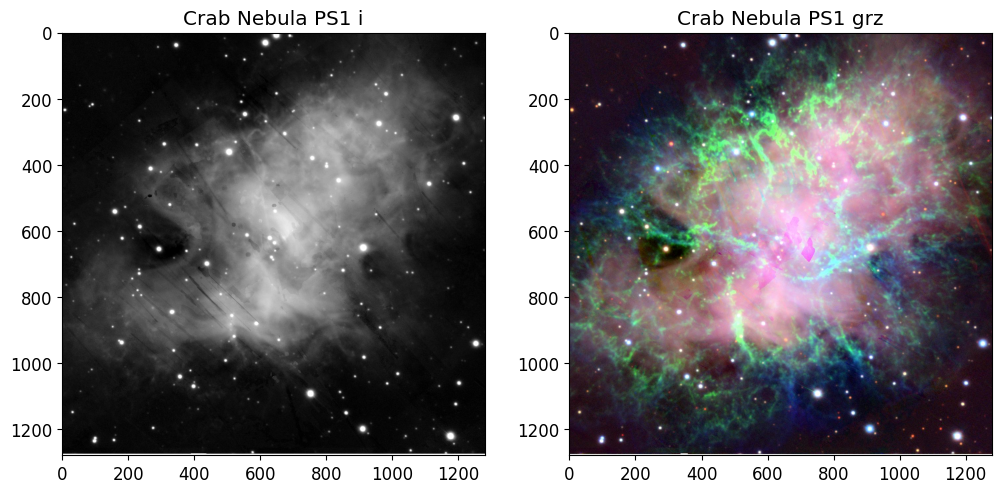

In [4]:
# Crab Nebula position
ra = 83.633210
dec = 22.014460
size = 1280

# grayscale image
gim = getgrayim(ra,dec,size=size,filter="i")
# color image
cim = getcolorim(ra,dec,size=size,filters="grz")

plt.rcParams.update({'font.size':12})
plt.figure(1,(12,6))
plt.subplot(121)
plt.imshow(gim,origin="upper",cmap="gray")
plt.title('Crab Nebula PS1 i')
plt.subplot(122)
plt.title('Crab Nebula PS1 grz')
plt.imshow(cim,origin="upper")

# Load and display a FITS image

Note that the y-axis is flipped in the JPEG image compared with the original FITS image.

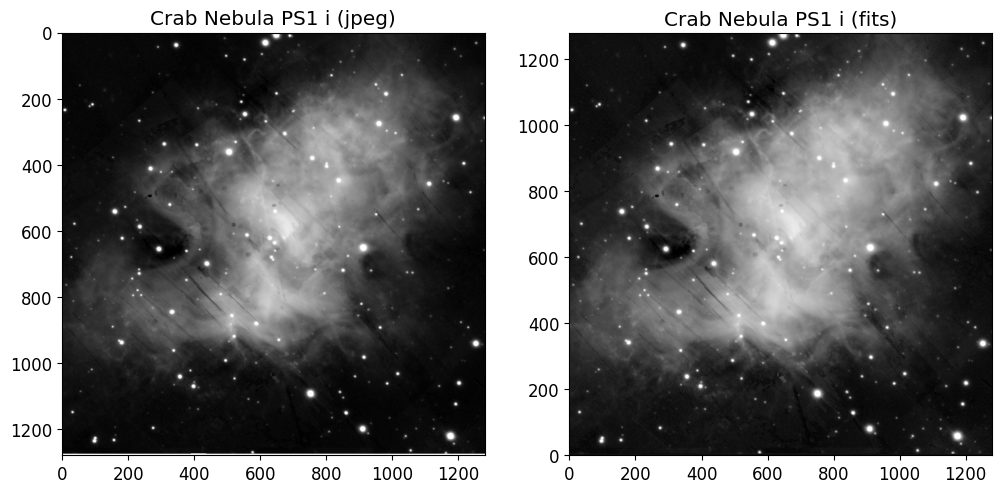

In [31]:
from astropy.io import fits
from astropy.visualization import PercentileInterval, AsinhStretch

fitsurl = geturl(ra, dec, size=size, filters="i", format="fits")
fh = fits.open(fitsurl[0])
fim = fh[0].data
# replace NaN values with zero for display
fim[numpy.isnan(fim)] = 0.0
# set contrast to something reasonable
transform = AsinhStretch() + PercentileInterval(99.5)
bfim = transform(fim)

plt.figure(1,(12,6))
plt.subplot(121)
plt.imshow(gim,cmap="gray",origin="upper")
plt.title('Crab Nebula PS1 i (jpeg)')

plt.subplot(122)
plt.title('Crab Nebula PS1 i (fits)')
plt.imshow(bfim,cmap="gray",origin="lower")

# Making a color image with individual filters

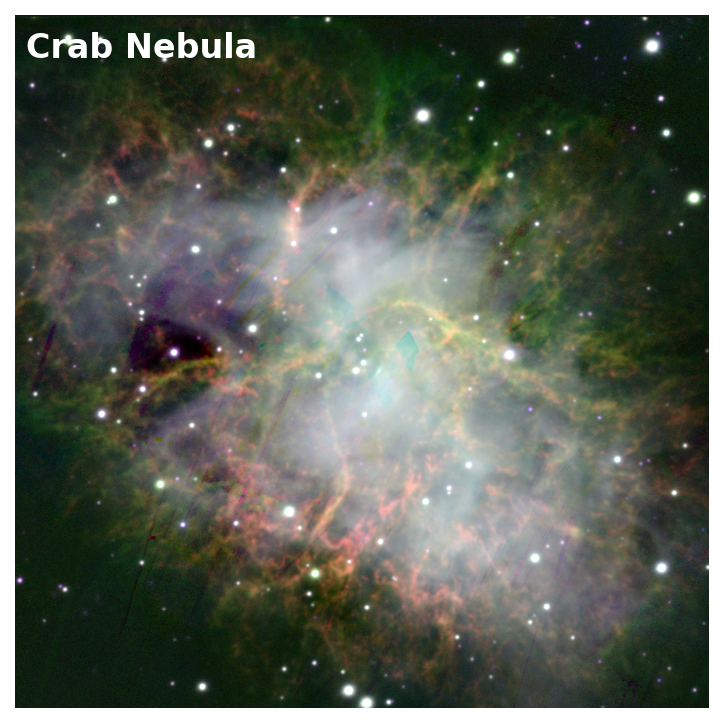

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.visualization import AsinhStretch, PercentileInterval

filters = ['g', 'r', 'i']
color_dict = {'g': 'Blues', 'r': 'Greens', 'i': 'Reds'}

# Create an empty RGB image
rgb_image = np.zeros((size, size, 3))

plt.figure(dpi=150, figsize=(12, 6))

for i, color in enumerate(filters):
    fitsurl = geturl(ra, dec, size=size, filters=color, format="fits")
    fh = fits.open(fitsurl[0])
    fim = fh[0].data

    # Replace NaN values with zero for display
    fim[np.isnan(fim)] = 0.0

    # Set contrast to something reasonable
    transform = AsinhStretch() + PercentileInterval(99.5)
    bfim_scaled = transform(fim)


    # Assign to the corresponding channel in the RGB image
    if color == 'g':
        rgb_image[..., 1] = bfim_scaled  # Green channel
    elif color == 'r':
        rgb_image[..., 0] = bfim_scaled  # Red channel
    elif color == 'i':
        rgb_image[..., 2] = bfim_scaled  # Blue channel

# Display the RGB image
plt.imshow(rgb_image)
plt.axis('off')  # Turn off axis labels
# put white text that says crab nebula in upper left corner
plt.text(20, 30, 'Crab Nebula', color='white', fontsize=16, fontweight='bold', ha='left', va='top')
plt.show()

# After querying the .fits image, we can then save it as a fits file to be used later

PANSTARRS is not the only plce you can get images, but is a nice resource.

In [7]:
fitsurl = geturl(ra, dec, size=size, filters="i", format="fits")
fh = fits.open(fitsurl[0])
fits.writeto("crab_ps1_i.fits",fh[0].data, overwrite=True)

## What are FITS Files?

FITS (Flexible Image Transport System) is the most commonly used digital file format in astronomy. It is specifically designed for the storage, transmission, and processing of scientific and astronomical data. Let's break down what makes FITS files unique and why they are so important in the field of astronomy.

### Structure of a FITS File

A FITS file is made up of one or more Header Data Units (HDUs). Each HDU contains two main components:

1. **Header**: A collection of metadata about the data, stored as ASCII text in 80-character keyword records. Each keyword record consists of a keyword, a value, and an optional comment. The header provides crucial information such as the size of the data, the data format, the units of measurement, and calibration parameters.

2. **Data**: The actual scientific data, which can be an image, a table, or a series of spectra. The data can be in various formats, including integers, floating-point numbers, or even text.

### Types of HDUs

1. **Primary HDU**: The first HDU in a FITS file. It often contains the primary data array, typically a 2D image.

2. **Image Extension HDU**: Additional HDUs that can store more images or multi-dimensional data.

3. **Table HDU**: Used to store tabular data, which is common for storing catalogs of stars, galaxies, or other astronomical objects.

4. **Binary Table HDU**: More efficient for storing complex tabular data, including data with mixed types (e.g., integers, floats, and strings).

### Why Do We Use FITS Files?

FITS files are tailored to meet the needs of astronomers and researchers for several reasons:

1. **Self-describing Format**: The header contains all the necessary information to understand the data. This makes the file self-describing, meaning anyone can read the file and understand the data without needing additional documentation.

2. **Versatility**: FITS files can store images, spectra, and tables all in one file. This makes it easy to package and distribute complex datasets.

3. **Metadata Storage**: The header can store extensive metadata about the observation, including details about the telescope, instrument settings, observation time, and data calibration.

4. **Portability**: FITS is a standard format that is widely supported by astronomy software, ensuring that FITS files can be easily shared and used across different platforms and tools.

5. **Precision**: FITS supports high-precision data storage, which is critical for scientific measurements.

--------------------------------------------------------------------------------

### Example FITS File Header

**Here's an example of what a FITS file header might look like:**

SIMPLE = T / file conforms to FITS standard

BITPIX = -32 / number of bits per data pixel

NAXIS = 2 / number of data axes

NAXIS1 = 1024 / length of data axis 1

NAXIS2 = 1024 / length of data axis 2

EXTEND = T / FITS dataset may contain extensions

COMMENT FITS (Flexible Image Transport System) format is defined in 'Astronomy

COMMENT and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H

**Each line in the header provides important information about the data stored in the file.**

--------------------------------------------------------------------------------


## Working with FITS Files

Now that we understand the basics of FITS files, let's start by loading a FITS file and examining its contents.


In [9]:
from astropy.io import fits

# Open a FITS file
file_path = 'crab_ps1_i.fits'
hdul = fits.open(file_path)

# Display information about the FITS file
hdul.info()


Filename: crab_ps1_i.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   (1280, 1280)   float32   


## Viewing FITS File Contents

FITS files can contain multiple Header Data Units (HDUs). Each HDU can have a header and data section. Let's view the header and data of the primary HDU.


In [10]:
# Get the primary HDU
primary_hdu = hdul[0]

# Print the header
print(primary_hdu.header)


SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                  -32 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                 1280                                                  NAXIS2  =                 1280                                                  EXTEND  =                    T                                                  END                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

In [11]:
# Get the data
image_data = primary_hdu.data

# Display the data type and shape
print(type(image_data))
print(image_data.shape)


<class 'numpy.ndarray'>
(1280, 1280)


## Visualizing FITS Data

We can use Matplotlib to visualize the data contained in a FITS file. Let's plot the image data.


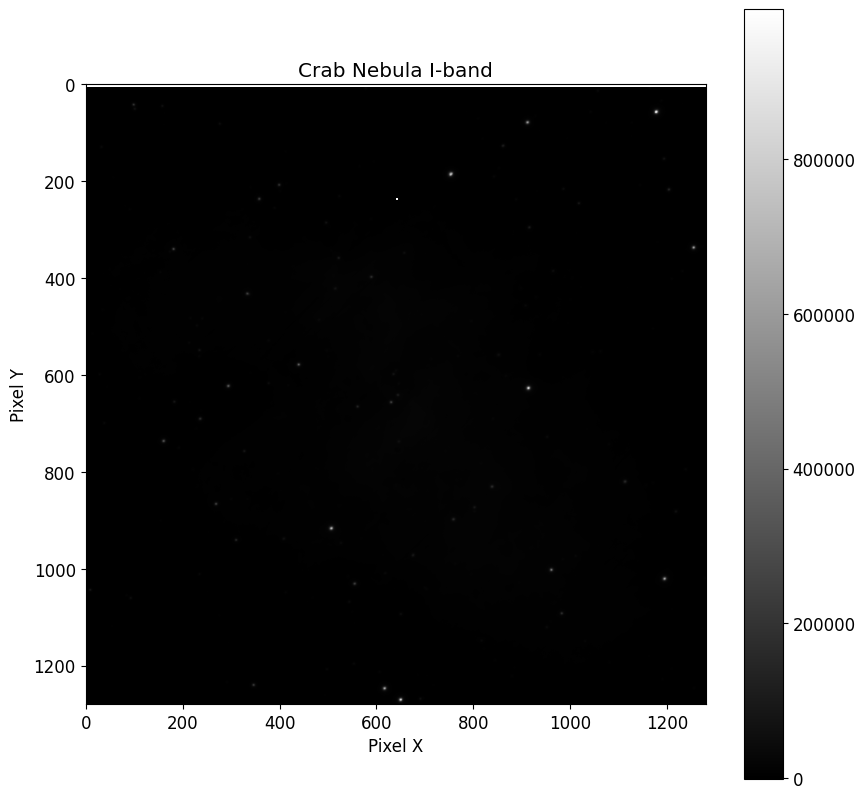

In [12]:
import matplotlib.pyplot as plt

# Plot the image data
plt.figure(figsize=(10, 10))
plt.imshow(image_data, cmap='gray')
plt.colorbar()
plt.title('FITS Image Data')
plt.title('Crab Nebula I-band')
plt.xlabel('Pixel X')
plt.ylabel('Pixel Y')
plt.show()


# Oh no, why can't we see out image very well?

# The issue is scaling. Our displays and images do not have the dynamic range to display a scale spanning the entire range of values that .fits images could have. This means we need to change the minumum and maximum value to better capture the majority of the data.

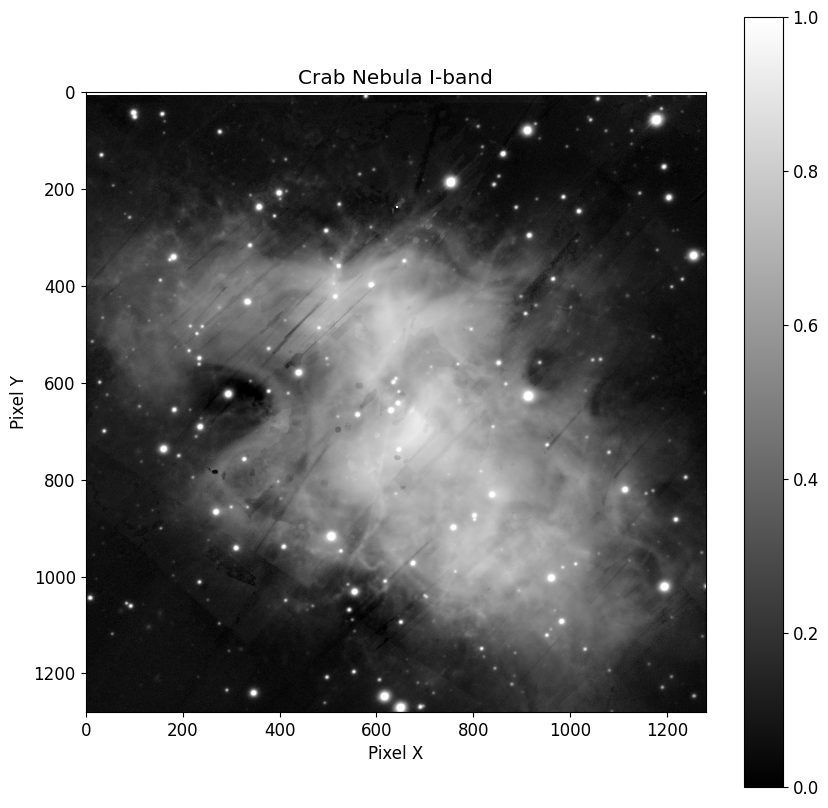

In [13]:

# set contrast to something reasonable
transform = AsinhStretch() + PercentileInterval(99.5)
scaled_image = transform(image_data)

# Plot the image data
plt.figure(figsize=(10, 10))
plt.imshow(scaled_image, cmap='gray')
plt.colorbar()
plt.title('Crab Nebula I-band')
plt.xlabel('Pixel X')
plt.ylabel('Pixel Y')
plt.show()

## World Coordinate System (WCS)

The World Coordinate System (WCS) is a crucial concept in astronomy that allows us to map the positions of objects in images to real-world coordinates, such as right ascension (RA) and declination (Dec) in the sky.

### What is WCS?

WCS is a framework that defines a transformation between pixel coordinates in an image (like those from a telescope) and celestial coordinates on the sky. Essentially, it provides a way to translate the position of a pixel in an image to a meaningful location in the universe.

### Why Do We Need WCS?

When astronomers take images of the sky, the data is captured in pixel coordinates. However, to compare these images with other observations or to identify objects in a star catalog, we need to know the actual positions of these objects in the sky. WCS allows us to:

1. **Identify Objects**: Match objects in the image with known objects in astronomical catalogs.
2. **Coordinate Transformation**: Convert between different coordinate systems (e.g., from pixel coordinates to RA/Dec).
3. **Overlay Data**: Combine and compare data from different sources or telescopes by aligning their coordinates.

### How Does WCS Work?

A WCS is defined in the header of a FITS file using specific keywords that describe the transformation. These include information about the reference pixel, the coordinates of the reference point, the scale (how pixel size translates to angular size), and any rotation or distortion.

### Example

Let's say we have a FITS image of a region in the sky. Using the WCS information in the FITS header, we can determine the RA and Dec of any pixel in that image. This allows us to find out what part of the sky we are looking at and to identify celestial objects within the image.

Now, let's load a FITS file with WCS information and explore it.


In [14]:
from astropy.wcs import WCS

# Load a FITS file with WCS information
wcs_file = 'crab_ps1_i.fits'
wcs_hdul = fits.open(wcs_file)
wcs = WCS(wcs_hdul[0].header)

# Print the WCS information
print(wcs)


WCS Keywords

Number of WCS axes: 2
CTYPE : '' '' 
CRVAL : 0.0 0.0 
CRPIX : 0.0 0.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : 1.0 1.0 
NAXIS : 1280  1280


In [15]:
# Convert pixel coordinates to world coordinates (RA, Dec)
pixel_coords = [[100, 100], [200, 200]]
world_coords = wcs.pixel_to_world(pixel_coords)
print(world_coords)


[<Quantity [101., 101.]>, <Quantity [201., 201.]>]


## Using SAOds9

SAOds9 is a popular tool for visualizing astronomical FITS images. While we can't directly integrate it in this notebook, you can use it to load and analyze FITS files interactively.

To open a FITS file in SAOds9:

1. Launch SAOds9.
2. Open your FITS file by navigating to `File > Open` and selecting your FITS file.
3. Use the various tools available in SAOds9 to explore your data.

For more details, refer to the [SAOds9 documentation](http://ds9.si.edu/doc/).


## Exploring AstroPy

AstroPy is a comprehensive library for astronomy in Python. It provides tools for reading and writing data, handling coordinates, time conversions, and much more. Let's explore some of its key functionalities.


### Coordinates

AstroPy makes it easy to work with astronomical coordinates. Let's convert between different coordinate systems.


In [16]:
from astropy.coordinates import SkyCoord
from astropy import units as u

# Define a coordinate in the ICRS system (RA, Dec)
coord = SkyCoord(ra=10.684*u.deg, dec=41.269*u.deg, frame='icrs')
print(coord)


<SkyCoord (ICRS): (ra, dec) in deg
    (10.684, 41.269)>


In [17]:
# Convert to Galactic coordinates
coord_galactic = coord.galactic
print(coord_galactic)


<SkyCoord (Galactic): (l, b) in deg
    (121.1737667, -21.57303963)>


## Time in Astronomy

Time is a fundamental aspect of astronomical observations. Precise timekeeping is crucial for correlating observations, scheduling telescope operations, and tracking celestial events. In astronomy, we use specialized time scales to account for the Earth's rotation and orbital motion.

### Julian Date (JD)

Julian Date (JD) is a continuous count of days and fractions of a day since the beginning of the Julian Period on January 1, 4713 BCE at noon (12:00 UTC). It is commonly used in astronomy because it provides a simple and consistent way to measure time over long periods.

### Modified Julian Date (MJD)

Modified Julian Date (MJD) is a variation of Julian Date, which subtracts 2400000.5 days from the Julian Date. This shifts the starting point to midnight on November 17, 1858. MJD is often used to keep the numbers smaller and more manageable, especially in computer systems.

#### Why Use JD and MJD?

1. **Continuity**: JD and MJD provide a continuous count of time, unlike calendar dates which have varying lengths of months and leap years.
2. **Precision**: These time scales allow for high-precision time measurements, which are essential for accurate astronomical observations and calculations.
3. **Simplification**: Using JD and MJD simplifies time arithmetic, making it easier to calculate intervals between observations.

### AstroPy and Time Handling

AstroPy provides tools to work with different time scales and formats, making it easy to handle and convert times for astronomical purposes.

Let's explore some examples of how to work with time in AstroPy.


In [21]:
from astropy.time import Time

# Get the current time
current_time = Time.now()
print(current_time)


2024-07-07 21:26:06.471508


In [22]:
# Convert to Julian Date
jd = current_time.jd
print(f'Julian Date: {jd}')


Julian Date: 2460499.3931304575


In [23]:
# Convert to Modified Julian Date
mjd = current_time.mjd
print(f'Modified Julian Date: {mjd}')


Modified Julian Date: 60498.89313045727


AstroPy allows for easy conversion between different time formats and scales. Here are some examples of converting between calendar dates and Julian dates.


In [24]:
# Define a specific calendar date
calendar_date = Time('2024-07-01T00:00:00', format='isot', scale='utc')

# Convert to Julian Date
jd_date = calendar_date.jd
print(f'Julian Date: {jd_date}')

# Convert to Modified Julian Date
mjd_date = calendar_date.mjd
print(f'Modified Julian Date: {mjd_date}')


Julian Date: 2460492.5
Modified Julian Date: 60492.0


### Units and Constants

AstroPy allows for easy unit conversions and provides a comprehensive list of physical constants.


In [25]:
from astropy.constants import c

# Speed of light
print(f'Speed of light: {c}')


Speed of light: 299792458.0 m / s


In [26]:
# Convert speed of light to km/s
c_km_s = c.to(u.km/u.s)
print(f'Speed of light in km/s: {c_km_s}')


Speed of light in km/s: 299792.458 km / s


## Tables

AstroPy provides powerful tools for working with tabular data. This is useful for handling large datasets, such as star catalogs. It's similar in use to Pandas and data can largely accessed in the same way

Let's create a table and perform some basic operations.


In [27]:
from astropy.table import Table

# Create a simple table
data = {'star': ['Sirius', 'Canopus', 'Arcturus'],
        'RA': [101.2875, 95.9879, 213.9154],
        'Dec': [-16.7161, -52.6957, 19.1825]}
table = Table(data)

# Display the table
print(table)


  star      RA      Dec   
-------- -------- --------
  Sirius 101.2875 -16.7161
 Canopus  95.9879 -52.6957
Arcturus 213.9154  19.1825


We can also read and write tables from/to various formats, such as CSV, FITS, and more.


In [28]:
# Write table to a CSV file
table.write('stars.csv', format='csv', overwrite=True)

# Read table from a CSV file
table_read = Table.read('stars.csv', format='csv')
print(table_read)


  star      RA      Dec   
-------- -------- --------
  Sirius 101.2875 -16.7161
 Canopus  95.9879 -52.6957
Arcturus 213.9154  19.1825


## Summary

In this homework, we've covered how to work with FITS files using AstroPy, explored various functionalities of the AstroPy library, and visualized data. Use these tools and techniques to analyze astronomical data and deepen your understanding of the universe.

For further reading and detailed tutorials, refer to the [AstroPy documentation](http://docs.astropy.org/en/stable/).


# Activity

## Try loading in the fits file that you used to make a color image in DS9 and make a color image using matplotlib.

## You should find that DS9 is generally much easier to use, but plotting in python does have some occasional advantages, espesially if you need to make a large number of plots.

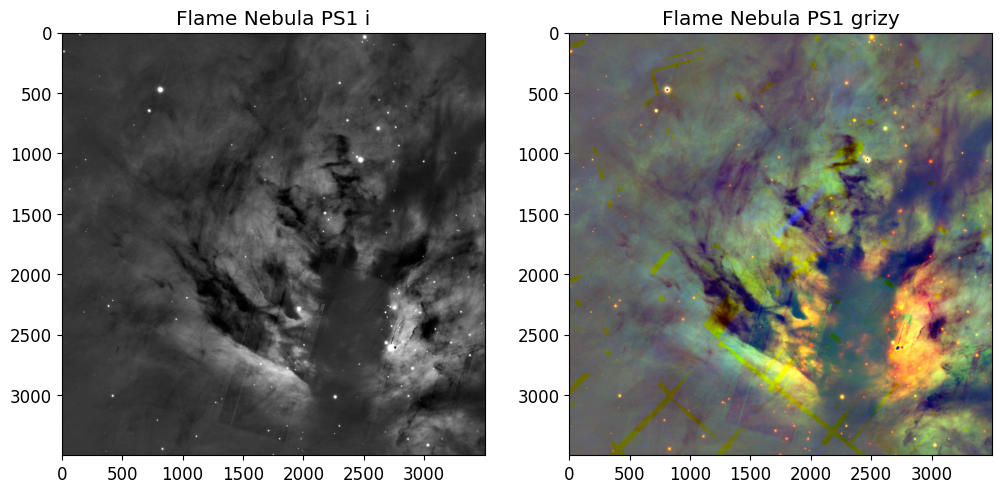

In [35]:
# Crab Nebula position
ra = 85.475
dec = -1.85
size = 3500

# grayscale image
gim = getgrayim(ra,dec,size=size,filter="i")
# color image
cim = getcolorim(ra,dec,size=size,filters="grizy")

plt.rcParams.update({'font.size':12})
plt.figure(1,(12,6))
plt.subplot(121)
plt.imshow(gim,origin="upper",cmap="gray")
plt.title('Flame Nebula PS1 i')
plt.subplot(122)
plt.title('Flame Nebula PS1 grizy')
plt.imshow(cim,origin="upper")

While this doesn't look exactly like some of the photos I found online, I did find one in wikipedia that says "Optical image in B, V, and R filters" and it has that very similar like short two prong-y, almost hand like look to it like my picture does here. It is rotated a little bit though, which probably just aligned it with North or something. I did also have to incerase the size to zoom out as the flame nebula is closer.